## Trade with ChatGPT

In [15]:
! git clone https://github.com/AI4Finance-Foundation/FinRL-Meta.git

Cloning into 'FinRL-Meta'...
remote: Enumerating objects: 7814, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 7814 (delta 22), reused 34 (delta 11), pack-reused 7761
Receiving objects: 100% (7814/7814), 169.33 MiB | 14.50 MiB/s, done.
Resolving deltas: 100% (4538/4538), done.
Updating files: 100% (418/418), done.


In [ ]:
%pip install git+https://github.com/carlosluis/stable-baselines3@fix_tests

In [2]:
%pip install akshare

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 33.8 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 14.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 32.9 MB/s eta 0:00:0000:01:00:01
  Created wheel for jsonpath: filename=jsonpath-0.82-py3-none-any.whl size=5610 sha256=2a4c1155dbfddccf9f8b6576037e18dbb07d57b6337ce0ca770cecee9326a96d
  Stored in directory: /home/codespace/.cache/pip/wheels/93/9d/2f/4dcbb0d8fdc7901bba9976a8f31f29f476460de7cb27259e2b
Successfully built jsonpath


In [3]:
import sys
sys.path.append(".\FinRL-Meta")  # Your FinRL-Meta dir
import pandas as pd
from meta.data_processors.akshare import Akshare
import datetime
import matplotlib.pyplot as plt

#### Read data

In [4]:
df = pd.read_csv("./data/maotai.csv")
df.head(1)

,CODE,NAME,DATE,CREATED_DATE,text_a,DESCRIPTION,READ,MARKET,CHANGE,FIRST_DAY,...,A0_mask,A1_mask,AV_num,trade_date,open_close_chg,co_label,cc_label,stock_factors,label,chatgpt_res
0,600519,贵州茅台,2021-01-07 18:24:00,2021-01-07 18:23:00,贵州茅台公告，董事会于2021年1月6日收到公司董事王焱的书面辞职报告，王焱因工作变动，申请...,贵州茅台公告，董事会于2021年1月6日收到公司董事王焱的书面辞职报告，王焱因工作变动，申请...,5034011.0,1.0,0.000935,2021-01-07,...,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....,3.0,2021-01-07,0.247727,4.0,4.0,"[39.43367824665831, 39.12671101868472, 39.9102...",1,在考虑董事辞职的情况下，以下是一个可能的回答：\n\n持有不动：基于董事辞职的信息，你可以选...


#### Generate Signal from ChatGPT

In [5]:
def generate_signal_from_chatgpt(x):
    chatgpt_res = x.chatgpt_res
    if "持有不动" in chatgpt_res:
        signal = 0
    if "小幅加仓" in chatgpt_res:
        signal = 1
    elif "小幅减仓" in chatgpt_res:
        signal = -1
    if "大幅加仓" in chatgpt_res:
        signal = 2
    elif "大幅减仓" in chatgpt_res:
        signal = -2
    return signal

In [6]:
df["signal"] = df.apply(generate_signal_from_chatgpt,axis = 1)

In [15]:
df["signal"]

0     0
1     1
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12   -2
13   -2
14   -2
Name: signal, dtype: int64

#### Generate Signal by yourself
Here the result of ChatGPT is just a suggestion, you need to make trading signal after considering both news and the result of ChatGPT

In [17]:
def generate_signal_from_chatgpt_by_yourself(x):
    chatgpt_res = x.chatgpt_res
    news = x.text_a
    signal = input(
        f'- {news}\n - {chatgpt_res}\n (Please input 1 for buy or 0 for hold or -1 for sell)'
        )
    return int(signal)

In [18]:
df["signal_by_yourself"] = df.apply(generate_signal_from_chatgpt_by_yourself,axis = 1)

In [19]:
df["signal_by_yourself"]

0    -1
1     1
2     1
3     0
4     0
5     0
6     0
7     1
8     1
9     0
10   -1
11    1
12   -1
13   -1
14    1
Name: signal_by_yourself, dtype: int64

#### Fetching price data from FinRL-Meta

In [7]:
df.DATE = pd.to_datetime(df.DATE)
df.DATE = df.DATE.dt.date.astype(str)
max_date = datetime.datetime.strptime(df.DATE.max(),"%Y-%m-%d")
max_date += datetime.timedelta(days=10)
max_date = max_date.strftime("%Y-%m-%d")

In [8]:
time_interval = "daily"
start_date= df.DATE.min()
end_date = max_date
adjust=""

ticket_list=[f'{df.iloc[0].CODE}.SH', ]

In [9]:
as_processor = Akshare("akshare",start_date=start_date,end_date=end_date,time_interval=time_interval)
as_processor.download_data(ticket_list)
as_processor.dataframe.shape

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.68s/it]

Download complete! Dataset saved to ./data/dataset.csv. 
Shape of DataFrame: (196, 8)


(196, 8)

#### Trading
Since we only have the news for several days here, we only calculated the dicision results made by Chatgpt or by combining Chatgpt and your own opinion

In [10]:
price_df = as_processor.dataframe
price_df = price_df.reset_index(drop=True)
price_df.head(1)

,tic,time,open,high,low,close,volume,day
0,600519.SH,2021-01-07,2097.0,2140.0,2075.0,2140.0,37931,3


In [12]:
def cal_reward(x,by_yourself = False, hold = False):
    # get price
    this_date = x.DATE
    this_price = price_df[price_df.time == this_date]
    
    while this_price.shape[0] == 0:
        this_date = datetime.datetime.strptime(this_date,"%Y-%m-%d")
        this_date += datetime.timedelta(days=1)
        this_date = this_date.strftime("%Y-%m-%d")
        this_price = price_df[price_df.time == this_date]
    
    next_price = price_df.iloc[this_price.index+1]
    this_close = this_price.close.item()
    next_open = next_price.open.item()
    next_close = next_price.close.item() # T+1
    
    if hold:
        signal = 1
    else:
        if by_yourself:
            signal = x.signal_by_yourself
        else:
            signal = x.signal

    reward = signal * (next_close-this_close)/this_close
    return reward


In [20]:
df["reward"] = df.apply(lambda x:cal_reward(x),axis = 1)
df["reward_by_yourself"] = df.apply(lambda x:cal_reward(x,by_yourself = True),axis = 1)
df["reward_hold"] = df.apply(lambda x:cal_reward(x,hold = True),axis = 1)

In [21]:
reward_list = (df["reward"] +1 ).cumprod().to_list()
reward_hold_list = (df["reward_hold"] +1 ).cumprod().to_list()
reward_yourself_list = (df["reward_by_yourself"] +1 ).cumprod().to_list()
reward_list = [i/reward_list[0] for i in reward_list]
reward_hold_list = [i/reward_hold_list[0] for i in reward_hold_list]
reward_yourself_list = [i/reward_yourself_list[0] for i in reward_yourself_list]


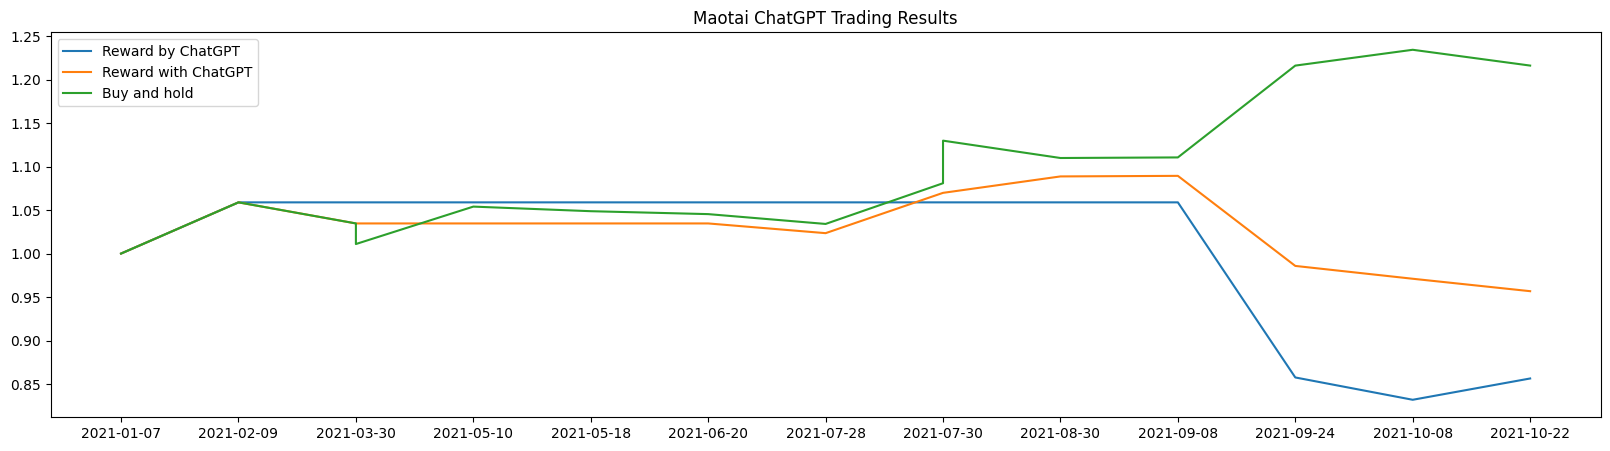

In [22]:
date_list = df.DATE
plt.figure(figsize=(20,5))
plt.plot(date_list, reward_list, label = "Reward by ChatGPT")
plt.plot(date_list, reward_yourself_list, label= "Reward with ChatGPT")
plt.plot(date_list, reward_hold_list, label= "Buy and hold")
plt.title("Maotai ChatGPT Trading Results")
plt.legend()
plt.show()